In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from scipy import stats
from scipy.integrate import odeint, solve_ivp
from scipy.stats import chi2_contingency

In [30]:
 # Import Dataset

 df = pd.read_csv('patient_data.csv')

# Q1: Outlier Deduction and Feature Reduction

In [31]:
# Use VarianceThreshold to remove constant features (if any).

variance_selector = VarianceThreshold(threshold=0)

numerical_cols = ['Age', 'CholesterolLevel', 'BloodPressure']
numerical_data = df[numerical_cols]

variance_selector.fit(numerical_data)
selected_features = variance_selector.get_support()

print(selected_features)

print(f"\nResult: No constant features found.")

[ True  True  True]

Result: No constant features found.


In [32]:
# Detect and remove outliers from CholesterolLevel using any method of choice.

Q1 = df['CholesterolLevel'].quantile(0.25)
Q3 = df['CholesterolLevel'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")

# Identify outliers
outliers = df[(df['CholesterolLevel'] < lower_bound) | (df['CholesterolLevel'] > upper_bound)]

print(f"\nOutliers found: {len(outliers)}")
if len(outliers) > 0:
    print("Outlier values:")
    print(outliers[['PatientID', 'CholesterolLevel']])

# Remove outliers
df_clean = df[(df['CholesterolLevel'] >= lower_bound) & (df['CholesterolLevel'] <= upper_bound)].copy()
print(f"\nDataset size after removing outliers: {df_clean.shape[0]} (removed {len(df) - len(df_clean)} outliers)")

Lower bound: 124.30, Upper bound: 271.30

Outliers found: 2
Outlier values:
    PatientID  CholesterolLevel
33         34             273.9
99        100             281.6

Dataset size after removing outliers: 98 (removed 2 outliers)


In [33]:
# Replace any missing values.

missing_values = df_clean.isnull().sum().sum()

if missing_values > 0:
    # Fill numerical columns with median
    for col in numerical_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)

    # Fill categorical columns with mode
    for col in ['Gender', 'Region', 'RiskCategory']:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


# Data Visualization

Text(0, 0.5, 'Blood Pressure (mmHg)')

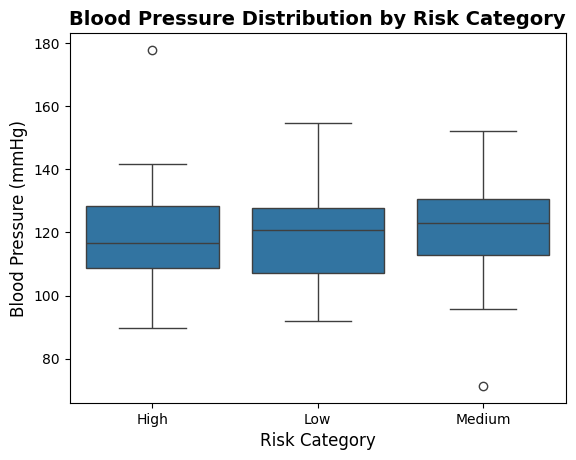

In [34]:
# Generate a box plot comparing BloodPressure between different RiskCategory levels

plot = sns.boxplot(data=df_clean, x='RiskCategory', y='BloodPressure')
plot.set_title('Blood Pressure Distribution by Risk Category', fontsize=14, fontweight='bold')
plot.set_xlabel('Risk Category', fontsize=12)
plot.set_ylabel('Blood Pressure (mmHg)', fontsize=12)

Text(0, 0.5, 'Number of Patients')

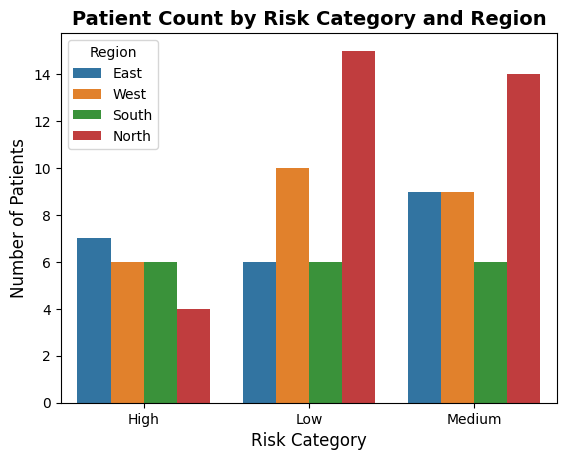

In [35]:
# 2. Count plot showing number of patients in each RiskCategory per Region

plot = sns.countplot(data=df_clean, x='RiskCategory', hue='Region')
plot.set_title('Patient Count by Risk Category and Region', fontsize=14, fontweight='bold')
plot.set_xlabel('Risk Category', fontsize=12)
plot.set_ylabel('Number of Patients', fontsize=12)

# Statistical Hypothesis Testing

In [36]:
# Is the average CholesterolLevel significantly different from 200 mg/dL having a sample size of 20?

np.random.seed(42)  # For reproducibility
sample_data = df_clean['CholesterolLevel'].sample(n=20, random_state=42)

print(f"\nHypothesis Test:")
print(f"Null Hypothesis: 200 mg/dL")
print(f"Alternative hypothesis ≠ 200 mg/dL")
print(f"Significance level: α = 0.05")

sample_mean = sample_data.mean()
sample_std = sample_data.std()

t_stat, p_value = stats.ttest_1samp(sample_data, 200)

print(f"\np-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"\nConclusion: Reject null hypotheses. The average cholesterol level is significantly different from 200 mg/dL")
else:
    print(f"\nConclusion: Fail to reject null hypothesis. No significant evidence that average cholesterol level differs from 200 mg/dL")


Hypothesis Test:
Null Hypothesis: 200 mg/dL
Alternative hypothesis ≠ 200 mg/dL
Significance level: α = 0.05

p-value: 0.2664

Conclusion: Fail to reject null hypothesis. No significant evidence that average cholesterol level differs from 200 mg/dL


In [37]:
# Is there a significant relationship between Region and RiskCategory?

contingency_table = pd.crosstab(df_clean['Region'], df_clean['RiskCategory'])

print(f"\nContingency Table:")
print(contingency_table)

print(f"\nHypothesis Test:")
print(f"Null Hypothesis: Region and RiskCategory are independent")
print(f"Alternative Hypothesis: Region and RiskCategory are not independent")
print(f"Significance level: α = 0.05")

# Chi-square test of independence
chi2_stat, p_value_chi2, dof, expected = chi2_contingency(contingency_table)

print(f"\nTest Results:")
print(f"p-value: {p_value_chi2}")

if p_value_chi2 < alpha:
    print(f"Conclusion: Reject null hypotheses. There is a significant relationship between Region and RiskCategory")
else:
    print(f"Conclusion: Fail to reject null hypothesis. No significant relationship between Region and RiskCategory")


Contingency Table:
RiskCategory  High  Low  Medium
Region                         
East             7    6       9
North            4   15      14
South            6    6       6
West             6   10       9

Hypothesis Test:
Null Hypothesis: Region and RiskCategory are independent
Alternative Hypothesis: Region and RiskCategory are not independent
Significance level: α = 0.05

Test Results:
p-value: 0.5664877563797075
Conclusion: Fail to reject null hypothesis. No significant relationship between Region and RiskCategory


# Modeling a Health System with ODE

In [38]:
# Model the progression of a patient's medication in the bloodstream.

print(f"Differential Equation: dC/dt = k(D - C)")
print(f"Parameters: k = 0.1, D = 100, C(0) = 0")
print(f"Time range: t = 0 to 50")

# Solve this ODE for t = 0 to 50 using both odeint and solve_ivp

def medication_ode(C, t, k, D):
    """
    Differential equation for medication concentration
    dC/dt = k(D - C)
    """
    dCdt = k * (D - C)
    return dCdt

def medication_ode_ivp(t, C, k, D):
    """
    Same ODE but in format required for solve_ivp
    """
    dCdt = k * (D - C)
    return [dCdt]

# Parameters
k = 0.1
D = 100
C0 = 0
t_span = (0, 50)
t_eval = np.linspace(0, 50, 501)

print(f"\nSolving ODE using two methods:")

# Method 1: Using odeint
print(f"1. Using odeint...")
solution_odeint = odeint(medication_ode, C0, t_eval, args=(k, D))
C_odeint = solution_odeint.flatten()

# Method 2: Using solve_ivp
print(f"2. Using solve_ivp...")
solution_ivp = solve_ivp(medication_ode_ivp, t_span, [C0],
                        t_eval=t_eval, args=(k, D), method='RK45')
C_ivp = solution_ivp.y[0]

Differential Equation: dC/dt = k(D - C)
Parameters: k = 0.1, D = 100, C(0) = 0
Time range: t = 0 to 50

Solving ODE using two methods:
1. Using odeint...
2. Using solve_ivp...


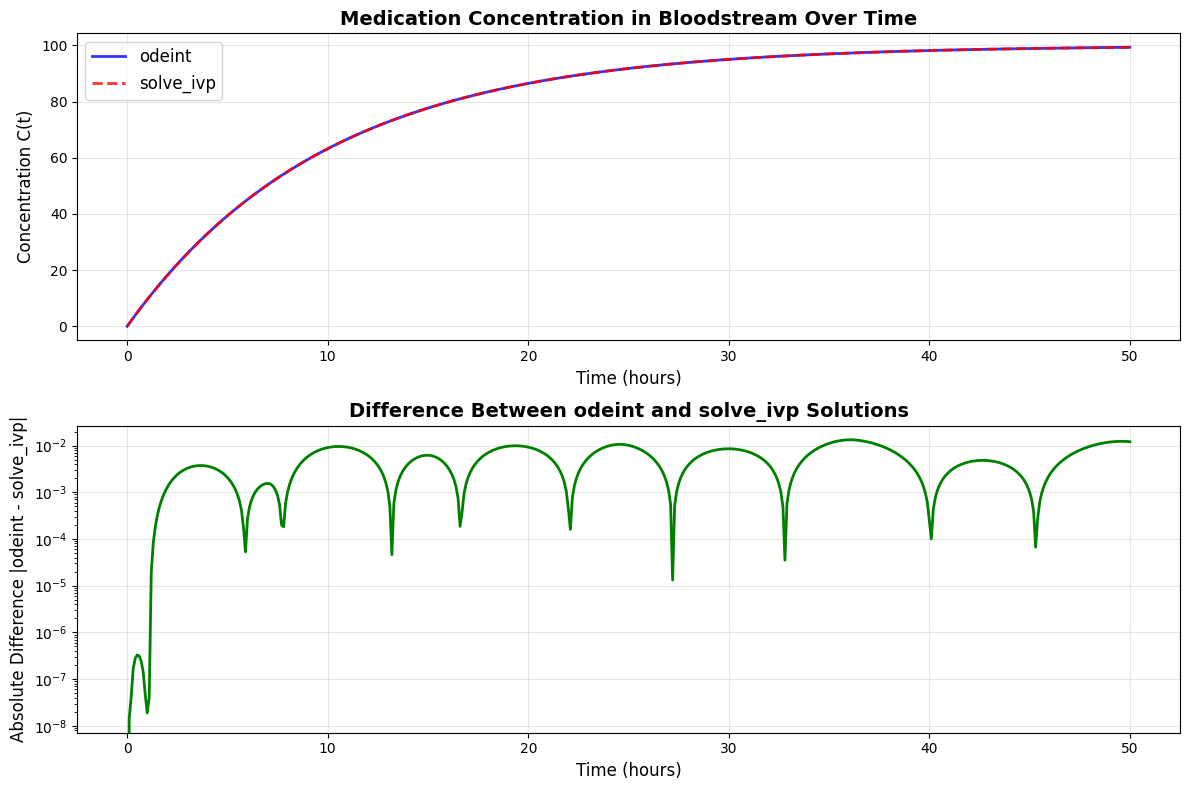


The differences between odeint and solve_ivp are minimal which indicates both solvers are highly accurate for this problem.

For practical purposes, both solutions are identical and the medication concentration approaches the steady state of 100 units asymptotically.



In [39]:
# Plot the result and explain the difference in output between the two solvers, if any.

plt.figure(figsize=(12, 8))

# Main plot
plt.subplot(2, 1, 1)
plt.plot(t_eval, C_odeint, 'b-', linewidth=2, label='odeint', alpha=0.8)
plt.plot(t_eval, C_ivp, 'r--', linewidth=2, label='solve_ivp', alpha=0.8)
plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('Concentration C(t)', fontsize=12)
plt.title('Medication Concentration in Bloodstream Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Difference plot
plt.subplot(2, 1, 2)
difference = np.abs(C_odeint - C_ivp)
plt.plot(t_eval, difference, 'g-', linewidth=2)
plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('Absolute Difference |odeint - solve_ivp|', fontsize=12)
plt.title('Difference Between odeint and solve_ivp Solutions', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale to better see small differences

plt.tight_layout()
plt.show()

print(f"""
The differences between odeint and solve_ivp are minimal which indicates both solvers are highly accurate for this problem.

For practical purposes, both solutions are identical and the medication concentration approaches the steady state of 100 units asymptotically.
""")